In [9]:
%matplotlib inline
from IPython.core.display import HTML

HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;
}
</style>
""")
import pandas as pd
import numpy as np
df = pd.read_csv('https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv')


# Remove % sign from DtI Ratio and interest rate
df['Debt.To.Income.Ratio'] = df['Debt.To.Income.Ratio'].apply(lambda x: x[:-1]).astype('float64')
df['Interest.Rate'] = df['Interest.Rate'].apply(lambda x: x[:-1]).astype('float64')

#Bucket categorical variables as float. Float type will allow easy removal of outliers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.State = le.fit_transform(df.State).astype('float64')
df['Home.Ownership'] = le.fit_transform(df['Home.Ownership']).astype('float64')


#extract float val from string
def numonly(string):
    res = ''
    for x in string:
        if x.isdigit():
            res = res+x
    return int(res)
df.loc[:,'Loan.Length'] = df['Loan.Length'].apply(numonly).astype('float64')

#average te FICO Range/ convert to float
def noline(string):
    x = string.split('-')
    c = 0
    for y in x:
        y=int(y)
        c+=y
    return c/2
df.loc[:,'FICO.Range'] = df['FICO.Range'].apply(noline).astype('float64')


#delete superfluous features
del df['Loan.Purpose']
del df['Employment.Length']


#drop NaN values and remove outliers
df = df.dropna()
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [2]:
df.head()

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months
81174,20000,20000.0,8.90,36.0,14.90,36.0,0.0,6541.67,737.0,14.0,14272.0,2.0
99592,19200,19200.0,12.12,36.0,28.36,38.0,0.0,4583.33,717.0,12.0,11140.0,1.0
80059,35000,35000.0,21.98,60.0,23.81,4.0,0.0,11500.00,692.0,14.0,21977.0,1.0
15825,10000,9975.0,9.99,36.0,14.30,15.0,0.0,3833.33,697.0,10.0,9346.0,0.0
33182,12000,12000.0,11.71,36.0,18.78,27.0,4.0,3195.00,697.0,11.0,14469.0,0.0


## Visual Exploration

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

### Histograms

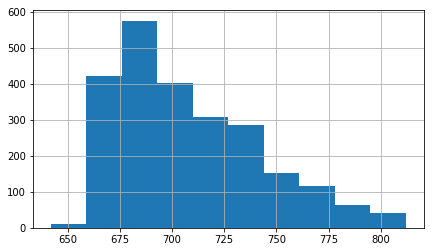

In [15]:
df['FICO.Range'].hist(figsize = (7,4))

### Box Plot

C:\Users\Harrison\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'                          ')

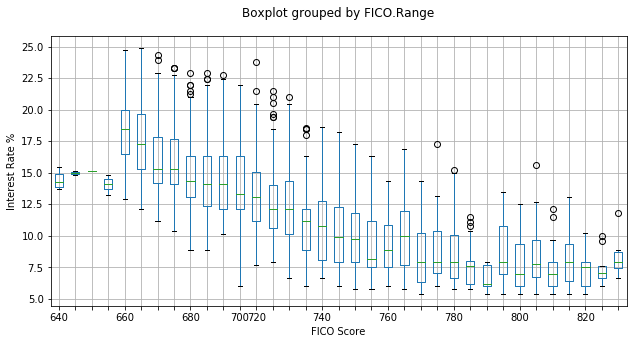

In [11]:
fig = plt.figure()
x = df.boxplot('Interest.Rate',  'FICO.Range', figsize=(10,5))
x.set_xticklabels(['640','','','','660','','','','680','','','700',
  '720','','','','740','','','','760','','','','780','','','','800','','','','820','','','','840'])
x.set_xlabel('FICO Score')
x.set_ylabel('Interest Rate %')
x.set_title('                          ')

From here we need to make a pairplot of all of the interesting variables that might effect interest rate. consider 

amount requested

FICO Score

Monthly Income

Loan Length

Interest Rate


from here you should see a relation to FICO Score and Loan Amount

In [18]:
subdf = df.drop([ 'Amount.Funded.By.Investors', 
        'Debt.To.Income.Ratio', 'State', 'Home.Ownership',
       'Open.CREDIT.Lines',
       'Revolving.CREDIT.Balance', 'Inquiries.in.the.Last.6.Months'], axis=1)
subdf.head()

,Amount.Requested,Interest.Rate,Loan.Length,Monthly.Income,FICO.Range
81174,20000,8.90,36.0,6541.67,737.0
99592,19200,12.12,36.0,4583.33,717.0
80059,35000,21.98,60.0,11500.00,692.0
15825,10000,9.99,36.0,3833.33,697.0
33182,12000,11.71,36.0,3195.00,697.0


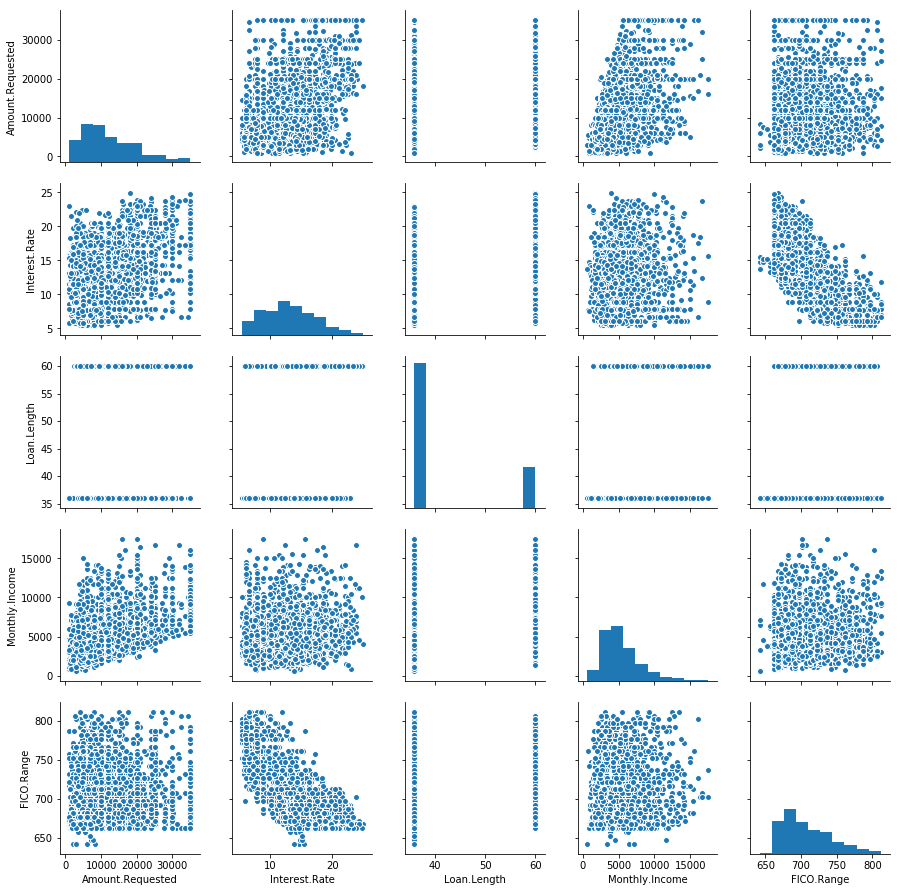

In [19]:
sns.pairplot(subdf)

## Time to Model

Lets start with OLE, I will not create a test set, but instead choose training accuracy since this is pretty rough and dirty.

In [49]:
import sklearn.linear_model as lm
x1 = df['FICO.Range'].values.reshape(-1,1)
x2 = df['Amount.Requested'].values.reshape(-1,1)
x_input = np.column_stack([x1,x2]) 


In [51]:
OLE = lm.LinearRegression()
OLE.fit(x_input, df['Interest.Rate'])
y_pred = OLE.predict(x_input)
OLE.score(x_input, df['Interest.Rate'])

0.66372612060997715

In [55]:
from sklearn.metrics import r2_score

r = r2_score(df['Interest.Rate'],y_pred)
print("coefficients",OLE.coef_,"and the intercept is:", OLE.intercept_)
print(r)

coefficients [-0.08983563  0.00021486] and the intercept is: 73.9662220521
0.66372612061


You Learn something new every day, the default score method for OLE regressor is already the R$^{2}$ statistic.

Now we need to research how to plot the residuals to look for heteroscedesticity and nonlinearity.

### Residuals

In [70]:
residuals = df['Interest.Rate'].values.reshape(-1,1) - y_pred.reshape(-1,1)




array([[-3.15465419],
       [-1.55947512],
       [ 2.65977297],
       ..., 
       [-0.85696764],
       [-2.01668728],
       [-1.74045933]])

## Hold Up!!!

https://medium.com/@dhwajraj/learning-python-regression-analysis-part-9-tests-and-validity-for-regression-models-78dcd5cde3a1

Gives a stats model that is way more informative, providing all of the statistics that I might need if I wanted tot do serious linear regression. Sklearn does not seem very full bodied.



In [ ]:
import statsmodels.formula.api as sm

